## 1. Set-up

In [1]:
import json
import re
import random
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

from transformers import AutoTokenizer, AutoModel

In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
def check_gpu():
    if torch.cuda.is_available():       
        print(f"There are {torch.cuda.device_count()} GPU(s) available.")
        print("Device name:", torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")
    return device


set_seed()
device = check_gpu()

There are 1 GPU(s) available.
Device name: GeForce RTX 2070


## 2. SciCite dataset

In [31]:
def load_data(filepath):
    d = {}
    with open(filepath) as f:
        for i, line in enumerate(f):
            d[i] = json.loads(line)
    return d

d = load_data("/home/jessica/data/SciCite/train.jsonl")
data = pd.DataFrame.from_dict(d).T

d2 = load_data("/home/jessica/data/SciCite/test.jsonl")
test = pd.DataFrame.from_dict(d2).T

# preview train
display(data.head())

# drop unnecessary columns
data = data.loc[:, ["string", "label"]]
test = test.loc[:, ["string", "label"]] 

# replace categorical label with integer
label_map = {"background": 0, "method": 1, "result": 2}
data["label"].replace(label_map, inplace=True)
test["label"].replace(label_map, inplace=True)

,source,citeEnd,sectionName,citeStart,string,label,label_confidence,citingPaperId,citedPaperId,isKeyCitation,id,unique_id,excerpt_index,label2,label2_confidence
0,explicit,175,Introduction,168,"However, how frataxin interacts with the Fe-S ...",background,1,1872080baa7d30ec8fb87be9a65358cd3a7fb649,894be9b4ea46a5c422e81ef3c241072d4c73fdc0,True,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,1872080baa7d30ec8fb87be9a65358cd3a7fb649>894be...,11,NaN,NaN
1,explicit,36,Novel Quantitative Trait Loci for Seminal Root...,16,"In the study by Hickey et al. (2012), spikes w...",background,1,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b,b6642e19efb8db5623b3cc4eef1c5822a6151107,True,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,ce1d09a4a3a8d7fd3405b9328f65f00c952cf64b>b6642...,2,NaN,NaN
2,explicit,228,Introduction,225,"The drug also reduces catecholamine secretion,...",background,1,9cdf605beb1aa1078f235c4332b3024daa8b31dc,4e6a17fb8d7a3cada601d942e22eb5da6d01adbd,False,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,9cdf605beb1aa1078f235c4332b3024daa8b31dc>4e6a1...,0,NaN,NaN
3,explicit,110,Discussion,46,By clustering with lowly aggressive close kin ...,background,1,d9f3207db0c79a3b154f3875c9760cc6b056904b,2cc6ff899bf17666ad35893524a4d61624555ed7,False,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,d9f3207db0c79a3b154f3875c9760cc6b056904b>2cc6f...,3,NaN,NaN
4,explicit,239,Discussion,234,Ophthalmic symptoms are rare manifestations of...,background,1,88b86556857f4374842d2af2e359576806239175,a5bb0ff1a026944d2a47a155462959af2b8505a8,False,88b86556857f4374842d2af2e359576806239175>a5bb0...,88b86556857f4374842d2af2e359576806239175>a5bb0...,2,NaN,NaN


In [6]:
# check: is the data balanced?
print(f"The training data consists of {len(data)} rows.")
print(data.label.value_counts())
print(f"\nThe test data consists of {len(test)} rows.")
print(test.label.value_counts())

# train-valid split
X_train, X_valid, y_train, y_valid = train_test_split(
    data.string, data.label, test_size=0.3
)
X_test, y_test = test.string, test.label

The training data consists of 9159 rows.
0    5378
1    2549
2    1232
Name: label, dtype: int64

The test data consists of 1861 rows.
0    997
1    605
2    259
Name: label, dtype: int64


## 4. Citation intent classifier based on BERT

### 4.1. Data preparation

In [13]:
def preprocessing(data, pretrained_weights, max_length=512):
    input_ids = []
    attention_mask = []

    tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
    for text in data:
        encodings = tokenizer.encode(
            text=text, 
            add_special_tokens=True, 
            truncation=True, 
            padding="max_length", 
            max_length=max_length
        )        
        input_ids.append(encodings)

    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(np.where(input_ids != 0, 1, 0))

    return input_ids, attention_mask

def create_dataloader(X, pretrained_weights, sampler, 
                      y=None, max_length=512, batch_size=32): 
    inputs, mask = preprocessing(X, pretrained_weights, max_length)
    if y is not None: 
        dataset = TensorDataset(inputs, mask, torch.tensor(y.values))
    else: 
        dataset = TensorDataset(inputs, mask)
    
    return DataLoader(dataset, 
                      sampler=sampler(dataset), 
                      batch_size=batch_size)

### 4.2. Model specification and related functions

In [8]:
class CiteBERT(nn.Module):
    def __init__(self, pretrained_weights, D_out, H=256, freeze_BERT=True):
        super().__init__()
        self.BERT = AutoModel.from_pretrained(pretrained_weights)
        self.classifier = nn.Sequential(
            nn.Linear(self.BERT.config.hidden_size, H), 
            nn.ReLU(), 
            nn.Linear(H, D_out)
        )

        if freeze_BERT: # do not update params of bert
            for param in self.BERT.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.BERT(input_ids=input_ids, 
                            attention_mask=attention_mask)
        
        logits = self.classifier(outputs[0][:, 0, :]) # only take CLS token
        return logits

In [17]:
def train(model, train_dataloader, valid_dataloader=None, epochs=2, device=None): 
    start = time.time()
    all_scores, all_losses = [], []
    for epoch_i in range(epochs):
        print("-"*30)
        print(f"| Epoch | Batch | Train Loss |")
        print("-"*30)
        
        epoch_start = time.time()
        model.train() 

        total_loss, b_loss, b_count = 0, 0, 0
        for step, batch in enumerate(train_dataloader):
            model.zero_grad() 
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            b_count += 1
            
            logits = model(b_input_ids, b_attn_mask) 
            
            loss = criterion(logits, b_labels) 
            b_loss += loss.item()
            total_loss += loss.item()

            loss.backward() 

            optimizer.step() 
            scheduler.step() 

            # print training results
            if (step%20 == 0 and step != 0) or (step==len(train_dataloader)-1):
                print(f"| {epoch_i+1:^5} | {step:^5} | {b_loss/b_count:^10.4f} |")
                b_loss, b_count = 0, 0
                
        avg_train_loss = total_loss/len(train_dataloader)
        
        print("-"*30)
        print(f"{'Avg. Train Loss:':^17} {avg_train_loss:^20.4f}")

        # evaluate current model on validation set
        if valid_dataloader: 
            model.eval() 

            valid_loss, precision, macro_avg_f1 = [], [], []
            for batch in valid_dataloader:
                b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

                with torch.no_grad(): 
                    logits = model(b_input_ids, b_attn_mask) 

                loss = criterion(logits, b_labels) 
                valid_loss.append(loss.item())

                proba = F.softmax(logits, dim=1).cpu().numpy()
                preds = np.argmax(proba, axis=1)
                report = classification_report(b_labels.tolist(), preds.tolist(), 
                                               output_dict=True, zero_division=0)

                if 2 in b_labels:
                    precision.append(report["2"]["precision"])
                if len(b_labels) > 1:
                    macro_avg_f1.append(report["macro avg"]["f1-score"])
                    
            # print training progress
            print(f"{'Avg. Valid Loss:':^17} {np.mean(valid_loss):^20.4f}")
            print(f"{'Mean Macro Avg. F1:':^20} {np.mean(macro_avg_f1):^14.4f}")
            print(f"{'Mean Precision, Class 2:':^20} {np.mean(precision):^.4f}") 
            
            all_scores.append({"precision": np.mean(precision), 
                               "macro_avg_f1": np.mean(macro_avg_f1)})
            all_losses.append({"train_loss": avg_train_loss, 
                               "valid_loss": np.mean(valid_loss)})
            

        print(f"\nTime taken: {round(time.time()-epoch_start, 4)}s")
        print("-"*30)

    print("\nTraining complete.")
    print(f"Time taken: {round(time.time()-start, 4)}s")    
    return all_scores, all_losses

def predict_proba(model, test_dataloader, device=None):
    model.eval()

    logits = []
    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            logits.append(model(b_input_ids, b_attn_mask))
    
    logits = torch.cat(logits, dim=0)
    proba = F.softmax(logits, dim=1).cpu().numpy()

    return proba

In [11]:
def make_plots(all_scores, all_losses=False, epochs=8):
    x = range(epochs)

    if all_losses: 
        train_loss = [all_losses[k]["train_loss"] for k in x]
        valid_loss = [all_losses[k]["valid_loss"] for k in x]
        plt.plot(x, train_loss, marker="x")
        plt.plot(x, valid_loss, marker="x")
        plt.legend(["train", "valid"], loc="upper left")
        plt.title("Macro-averaged F1-score")
        plt.ylabel("loss")
        plt.xlabel("epoch")
        plt.show()

    macro_avg_f1 = [all_scores[k]["macro_avg_f1"] for k in x]
    plt.plot(x, macro_avg_f1, marker="x")
    plt.title("Macro-averaged F1-score")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.show()

    precision = [all_scores[k]["precision"] for k in x]
    plt.plot(x, precision, marker="x")
    plt.title("Average Precision for Class 2")
    plt.ylabel("score")
    plt.xlabel("epoch")
    plt.show()

### 4.3. CiteDistilBERT

In [14]:
# specify parameters
MAX_LEN = 512
BATCH_SIZE = 32

# create train, validation, test dataloaders
train_dataloader = create_dataloader(
    X_train, pretrained_weights="distilbert-base-uncased", y=y_train, 
    sampler=RandomSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

valid_dataloader = create_dataloader(
    X_valid, pretrained_weights="distilbert-base-uncased", y=y_valid, 
    sampler=SequentialSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

test_dataloader  = create_dataloader(
    X_test, pretrained_weights="distilbert-base-uncased", y=y_test, 
    sampler=SequentialSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

In [20]:
EPOCHS = 8

# specify model, criterion, optimizer, scheduler
CiteDistilBERT = CiteBERT("distilbert-base-uncased", D_out=3)
criterion = nn.CrossEntropyLoss() 
optimizer = AdamW(CiteDistilBERT.parameters())
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(train_dataloader) * EPOCHS)

CiteDistilBERT.to(device)
all_scores, all_losses = train(
    CiteDistilBERT, train_dataloader, valid_dataloader, 
    epochs=EPOCHS, device=device
)

----------------------------
 Epoch | Batch | Train Loss
----------------------------
   1   |  20   |   0.8792  
   1   |  40   |   0.7206  
   1   |  60   |   0.6145  
   1   |  80   |   0.6285  
   1   |  100  |   0.6115  
   1   |  120  |   0.6121  
   1   |  140  |   0.6017  
   1   |  160  |   0.5359  
   1   |  180  |   0.5735  
   1   |  200  |   0.5795  
----------------------------
Avg. Train Loss:   0.6369  
Validation Loss:   0.5355  


Time taken: 107.9742
----------------------------
----------------------------
 Epoch | Batch | Train Loss
----------------------------
   2   |  20   |   0.5467  
   2   |  40   |   0.5181  
   2   |  60   |   0.5477  
   2   |  80   |   0.5330  
   2   |  100  |   0.5478  
   2   |  120  |   0.5116  
   2   |  140  |   0.5130  
   2   |  160  |   0.5509  
   2   |  180  |   0.4926  
   2   |  200  |   0.5275  
----------------------------
Avg. Train Loss:   0.5290  
Validation Loss:   0.4983  


Time taken: 108.8406
-----------------------

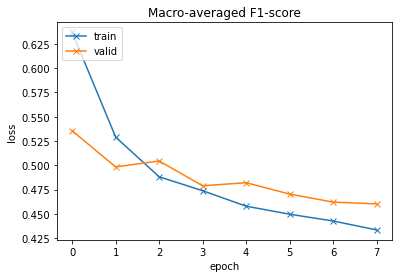

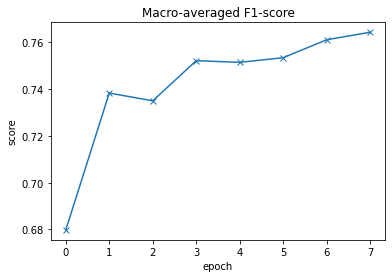

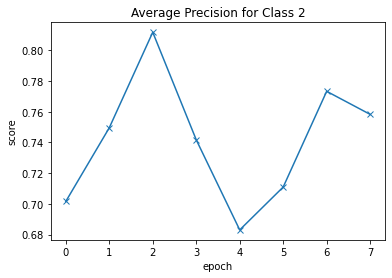

In [21]:
make_plots(all_scores, all_losses, epochs=EPOCHS)

In [32]:
# train new instance on full train data
total_dataloader = create_dataloader(
    data.string, pretrained_weights="distilbert-base-uncased", y=data.label, 
    sampler=RandomSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE
)

EPOCHS = 6 # chosen for high macro avg F1 and decent precision on class 2

# specify model, criterion, optimizer, scheduler
CiteDistilBERT = CiteBERT("distilbert-base-uncased", D_out=3)
criterion = nn.CrossEntropyLoss() 
optimizer = AdamW(CiteDistilBERT.parameters())
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(total_dataloader) * EPOCHS)

CiteDistilBERT.to(device)
_ = train(CiteDistilBERT, total_dataloader, epochs=EPOCHS, device=device)

----------------------------
 Epoch | Batch | Train Loss
----------------------------
   1   |  20   |   0.8621  
   1   |  40   |   0.7479  
   1   |  60   |   0.6801  
   1   |  80   |   0.6506  
   1   |  100  |   0.5971  
   1   |  120  |   0.5644  
   1   |  140  |   0.5666  
   1   |  160  |   0.6082  
   1   |  180  |   0.5624  
   1   |  200  |   0.5751  
   1   |  220  |   0.4905  
   1   |  240  |   0.5402  
   1   |  260  |   0.5180  
   1   |  280  |   0.5841  
   1   |  286  |   0.5036  
----------------------------
Avg. Train Loss:   0.6092  
Time taken: 108.536
----------------------------
----------------------------
 Epoch | Batch | Train Loss
----------------------------
   2   |  20   |   0.5502  
   2   |  40   |   0.5406  
   2   |  60   |   0.4908  
   2   |  80   |   0.5047  
   2   |  100  |   0.5044  
   2   |  120  |   0.5310  
   2   |  140  |   0.4642  
   2   |  160  |   0.5280  
   2   |  180  |   0.5123  
   2   |  200  |   0.4763  
   2   |  220  |   0.5

In [42]:
# evaluate model on test data
proba = predict_proba(CiteDistilBERT, test_dataloader, device=device)

# results
y_pred = pd.DataFrame(np.argmax(proba, axis=1), columns=["pred"])
print(classification_report(y_test, y_pred, digits=4))
display(pd.concat([test, y_pred], axis=1).head())

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [38]:
# save trained model
torch.save(CiteDistilBERT.state_dict(), "/home/jessica/Documents/models/CiteDistilBERT")

### 2.4. CiteSciBert

In [39]:
# specify parameters
MAX_LEN = 512
BATCH_SIZE = 32

# create train, validation, test dataloaders
train_dataloader = create_dataloader(
    X_train, pretrained_weights="allenai/scibert_scivocab_uncased", y=y_train, 
    sampler=RandomSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

valid_dataloader = create_dataloader(
    X_valid, pretrained_weights="allenai/scibert_scivocab_uncased", y=y_valid, 
    sampler=SequentialSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

test_dataloader  = create_dataloader(
    X_test, pretrained_weights="allenai/scibert_scivocab_uncased", y=y_test, 
    sampler=SequentialSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE)

----------------------------
 Epoch | Batch | Train Loss
----------------------------
   1   |  20   |   0.6733  
   1   |  40   |   0.5272  
   1   |  60   |   0.4894  
   1   |  80   |   0.5001  
   1   |  100  |   0.4328  
   1   |  120  |   0.5653  
   1   |  140  |   0.4914  
   1   |  160  |   0.4478  
   1   |  180  |   0.5201  
   1   |  200  |   0.4423  
----------------------------
Avg. Train Loss:   0.5098  
Validation Loss:   0.4468  


Time taken: 228.326
----------------------------
----------------------------
 Epoch | Batch | Train Loss
----------------------------
   2   |  20   |   0.4200  
   2   |  40   |   0.4318  
   2   |  60   |   0.4218  
   2   |  80   |   0.4844  
   2   |  100  |   0.4025  
   2   |  120  |   0.4456  
   2   |  140  |   0.4728  
   2   |  160  |   0.4558  
   2   |  180  |   0.4258  
   2   |  200  |   0.4045  
----------------------------
Avg. Train Loss:   0.4364  
Validation Loss:   0.4567  


Time taken: 230.3341
------------------------

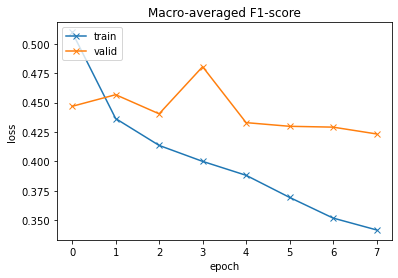

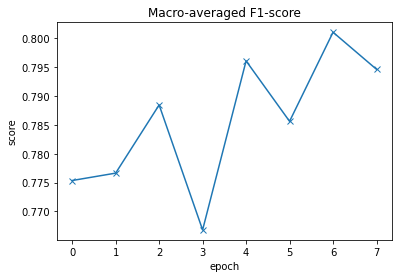

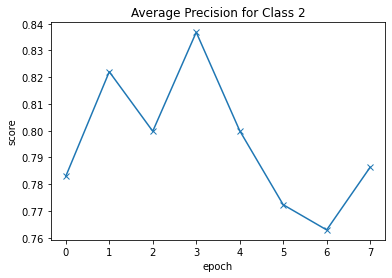

In [40]:
EPOCHS = 8

# specify model, criterion, optimizer, scheduler
CiteSciBERT = CiteBERT("allenai/scibert_scivocab_uncased", D_out=3)
criterion = nn.CrossEntropyLoss() 
optimizer = AdamW(CiteSciBERT.parameters())
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(train_dataloader) * EPOCHS)

CiteSciBERT.to(device)
all_scores, all_losses = train(
    CiteSciBERT, train_dataloader, valid_dataloader, 
    epochs=EPOCHS, device=device
)

# make plots of training progress
make_plots(all_scores, all_losses)

In [41]:
# train new instance on full train data
total_dataloader = create_dataloader(
    data.string, pretrained_weights="allenai/scibert_scivocab_uncased", y=data.label, 
    sampler=RandomSampler, max_length=MAX_LEN, batch_size=BATCH_SIZE
)

EPOCHS = 3 # chosen for high precision on class 2

# specify model, criterion, optimizer, scheduler
CiteSciBERT = CiteBERT("allenai/scibert_scivocab_uncased", D_out=len(label_map))
criterion = nn.CrossEntropyLoss() 
optimizer = AdamW(CiteSciBERT.parameters())
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(total_dataloader) * EPOCHS)

CiteSciBERT.to(device)
_ = train(CiteSciBERT, total_dataloader, epochs=EPOCHS, device=device)

----------------------------
 Epoch | Batch | Train Loss
----------------------------
   1   |  20   |   0.7364  
   1   |  40   |   0.5236  
   1   |  60   |   0.5144  
   1   |  80   |   0.4719  
   1   |  100  |   0.5058  
   1   |  120  |   0.5021  
   1   |  140  |   0.5137  
   1   |  160  |   0.4427  
   1   |  180  |   0.4350  
   1   |  200  |   0.4661  
   1   |  220  |   0.4793  
   1   |  240  |   0.5170  
   1   |  260  |   0.4174  
   1   |  280  |   0.4576  
   1   |  286  |   0.4123  
----------------------------
Avg. Train Loss:   0.4978  
Time taken: 234.7037
----------------------------
----------------------------
 Epoch | Batch | Train Loss
----------------------------
   2   |  20   |   0.4610  
   2   |  40   |   0.3919  
   2   |  60   |   0.4339  
   2   |  80   |   0.4670  
   2   |  100  |   0.4306  
   2   |  120  |   0.4504  
   2   |  140  |   0.4700  
   2   |  160  |   0.4272  
   2   |  180  |   0.3811  
   2   |  200  |   0.4309  
   2   |  220  |   0.

In [47]:
# evaluate model on test data
proba = predict_proba(CiteSciBERT, test_dataloader, device=device)

# results
y_pred = pd.DataFrame(np.argmax(proba, axis=1), columns=["pred"])
print(classification_report(y_test, y_pred, digits=4))
display(pd.concat([test, y_pred], axis=1).head())

RuntimeError: CUDA error: device-side assert triggered

In [30]:
# save trained model
torch.save(CiteSciBERT.state_dict(), "/home/jessica/models/CiteSciBERT")